<a href="https://colab.research.google.com/github/masala-man/gpt2-indiaspeaks/blob/main/GPT2_IndiaSpeaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**DIY IndiaSpeaks**





## 0. Setup Environment

Install all the packages we need and mount Google Drive and display the GPU allocated to us

If you're using Colab for the first time, make sure GPU acceleration is turned on and that you've pressed the Google Drive button in the Files section of the sidebar to provide access to your Drive.

(`Runtime > Change runtime type > GPU` to enable acceleration)

In [ ]:
# Install necessary packages
!pip install git+https://github.com/huggingface/transformers
!pip install datasets
!pip install pushshift.py
!pip install numpy
!pip install pandas
!pip install redditcleaner

import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('drive')

# Fetch training script
!wget wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/language-modeling/run_clm.py

# Display graphics card details
!nvidia-smi

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-sw1u2tho
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-sw1u2tho
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 870kB 5.8MB/s 
     |████████████████████████████████| 3.3MB 34.5MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2090005 sha256=b29a41386c1cba216a210567c85e8b99fb59a352d1cc7283b2f5a226934bfc0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmxifg4p/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=d1d1ca6aef1bc31bb17e7055420800d001fca3d19bbb372616c1ca0a15d1914b
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f44836674465432

## 1. Gather Data



### Scraping

Get posts from reddit. Use pushshift because the reddit API sucks.

In [ ]:
from pushshift_py import PushshiftAPI
import csv
import os
import datetime as dt
import pandas as pd
import numpy as np
import json 

########CONFIG########
sub_to_scrape = 'IndiaSpeaks'
data_to_fetch = ['title', 'selftext', 'url', 'author', 'created_utc']
output_path = "drive/MyDrive"
# end_epoch=int(dt.datetime(2020, 4, 1).timestamp())
######################

# Show all columns when displaying dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Scraping
api = PushshiftAPI()
scraped_data = list(api.search_submissions(
                            subreddit=sub_to_scrape,
                            filter=data_to_fetch,
                            is_self=True))

posts = {
    "title": [],
    "author": [],
    "selftext": [],
    "url": [],
    "date": []
}

# Form dataframe
for n,x in enumerate(scraped_data):
  posts['title'].append(scraped_data[n].d_['title'])
  posts['author'].append(scraped_data[n].d_['author'])
  posts['selftext'].append(scraped_data[n][2])
  posts['url'].append(scraped_data[n].d_['url'])
  posts['date'].append(dt.datetime.fromtimestamp(scraped_data[n].d_['created_utc']).strftime('%d-%m-%Y'))

df = pd.DataFrame(data=posts)
df['textlength'] = df['selftext'].str.len()
df['date'] = pd.to_datetime(df['date'])

### Show Data

Take a look at the collected data put in a dataframe

In [ ]:
print(df)
df.info()

                                                   title             author                                           selftext                                                url       date  textlength
0      Anyone suffering from Crohn’s disease in this ...        Mutant12123  Would like to get in touch with Indian brother...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04          99
1      Hi I am AnnyArun. An avid motorcycle tourer, a...           annyarun                                          [removed]  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04           9
2      Is an MBA from IGNOU worth it? What are pros /...         any-mystic  I am a software engineer with 5.5 years of exp...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04          54
3               help me fund a mushroom farming business         maitakeblr                                          [removed]  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04        

###Clean Data

Clean data of any removed or deleted posts

In [ ]:
import html
import redditcleaner

# Discard removed and deleted Posts from data
df = df[~df['selftext'].isin(['[deleted]', '[removed]'])]
df = df[~df['author'].isin(['[deleted]', '[removed]'])]
df = df.drop_duplicates(subset='selftext')

# Remove non-ASCII
def is_ascii(body):
  return all(ord(char) < 128 for char in body)
df = df[~df['selftext'].map(is_ascii) != True]

# Remove misencoded text
for misenc_word in [f'a {x*"?"} a' for x in range(2, 10)]:
  df = df[~df['selftext'].str.contains(misenc_word, regex=False)]

# Clean HTML encoding
df['title'] = df['title'].apply(lambda x: html.unescape(x))
df['selftext'] = df['selftext'].apply(lambda x: html.unescape(x))

# Clean encoding issues
df['selftext'] = df['selftext'].apply(lambda x: x.encode('cp1252','replace').decode('cp1252'))

# Remove markdown
df['selftext'] = df['selftext'].map(redditcleaner.clean)

# Reset Index
df = df.reset_index(drop=True)

# Save as CSV file for review
if os.path.exists('data.csv'):
  os.remove('data.csv')
df.to_csv(r'data.csv', index=False, encoding="utf8")

# Display cleaned data
print(df)

                                                   title              author                                           selftext                                                url       date  textlength
0      Anyone suffering from Crohn’s disease in this ...         Mutant12123  Would like to get in touch with Indian brother...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04          99
1      Is an MBA from IGNOU worth it? What are pros /...          any-mystic  I am a software engineer with 5.5 years of exp...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04          54
2                               *Belongs to SC community   West-Database1544  &x200B; https://preview.redd.it/hunq8upg06s61....  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04         142
3                                           India in UPA           insane-67  I was in a debate today wherein we were discus...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2021-09-04   

### Visualize Data

Check the distribution of post lengths

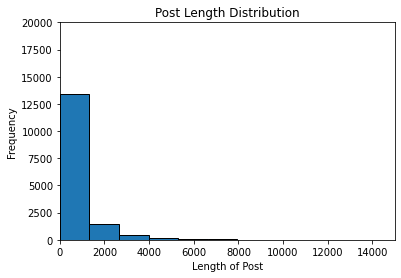

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['textlength'], bins=30, edgecolor = "black")
plt.title(r'Post Length Distribution')
plt.xlabel('Length of Post')
plt.ylabel('Frequency')
plt.axis([0, 15000, 0 , 20000])
plt.show()

### Save Data

Save the dataset in a format that can be passed to the training script

[Huggingface Docs](https://huggingface.co/docs/datasets/loading_datasets.html)

In [ ]:
# Shuffle
shuffled = df.sample(n=len(df), random_state=25)
print(shuffled)

# Divide the post data in a 9:10 training:eval ratio and write to files
if os.path.exists(f"{output_path}/aarav2-dev-training.txt"):
  os.remove(f"{output_path}/aarav2-dev-training.txt")
if os.path.exists(f"{output_path}/aarav2-dev-eval.txt"):
  os.remove(f"{output_path}/aarav2-dev-eval.txt")

dataset = open(f"{output_path}/aarav2-dev-training.txt", 'w', encoding="utf8")
eval = open(f"{output_path}/aarav2-dev-eval.txt", 'w', encoding="utf8")

point = round((9*len(df))/10)

for index, row in shuffled.iterrows():
  if index < point:
    dataset.write(row['selftext'] + '\n')
  else:
    eval.write(row['selftext'] + '\n')

                                                   title              author                                           selftext                                                url       date  textlength
12971  Know about right to property and 78th ammendme...  Sunset-in-the-east  All rights are not fundamental in nature like ...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2018-07-14        1073
7293              A thought provoking for the privileged           chirayu89  The Indian Express: Listen, Mister Muslim. You...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2019-11-14         261
1910             Do Indians join the army for the money?             AdiCrio  I recently got into an argument with an americ...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2020-08-19         193
2495                      Solution for COVID-19 Pandemic         Anantaniium  SUGGESTED SOLUTION : As we know that the world...  https://www.reddit.com/r/IndiaSpeaks/comments/... 2020-12-07   

 ## 2. Train Model
 
 Connect to a runtime with GPU acceleration and run.

In [ ]:
# Start training. should take about 30:00
!python run_clm.py --output_dir=drive/MyDrive/aarav2-dev --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_file=drive/MyDrive/aarav2-dev-training.txt --do_eval --validation_file=drive/MyDrive/aarav2-dev-eval.txt --per_device_train_batch_size=2 --per_device_eval_batch_size=2 --num_train_epochs=1

2021-04-10 07:07:07.252708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
04/10/2021 07:07:09 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
04/10/2021 07:07:09 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=drive/MyDrive/aarav3, overwrite_output_dir=False, do_train=True, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=2, per_device_eval_batch_size=2, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=1.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/Apr10_07-07-09_a01d947bab4b, logging_strategy=IntervalStrategy.STEPS, logging_first_s

## 3. Generate Text

Fetch our newly trained model and generate text with it.

[Huggingface Tutorial](https://huggingface.co/blog/how-to-generate)

[Colab Reference](https://colab.research.google.com/gist/GeorgeDittmar/5c57a35332b2b5818e51618af7953351/lm-huggingface-finetune-gpt-2.ipynb)


In [ ]:
from transformers import TFGPT2LMHeadModel
from transformers import GPT2Tokenizer

# Import the trained model
model = TFGPT2LMHeadModel.from_pretrained("drive/MyDrive/aarav2-dev", from_pt=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Generate new sequences from the trained model
generated_text_samples = model.generate(
    None, 
    max_length=300,  
    num_return_sequences=30,
    repetition_penalty=1.0,
    top_p=0.9,
    temperature=1.0,
    do_sample=True,
    top_k=50,
)

# Decode and display model output
for i, beam in enumerate(generated_text_samples):
  print("{}: {}".format(i,tokenizer.decode(beam, skip_special_tokens=True)))
  print()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'lm_head.weight', 'transformer.h.6.attn.masked_bias', 'transformer.h.11.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

0: This episode is sponsored by The Booking Podcast - The Booking Podcast is sponsored by Amazon.com and iTunes and Stitcher. You can buy it here. https://thebookingpodcast.com/ podcast/ booking-podcast/ It is sponsored by Amazon Gift Cards. If you buy any gift card, you can send money to Amazon via the card reader. The book is sponsored by Amazon. The book can be downloaded from Amazon and you can get it here: https://bookingpodcast.com/amazon/ book-book/ How does Booking podcasts differ from other podcast? &x200B; Please note: If you are new to podcasting or reading about it, please read the below links. &x200B;  &x200B;                                                                                                                                               

1: "We can all appreciate that we are better than this. We are not the only ones who suffer from this." - Dr. Tarek Mehbooba, an Indian doctor who was kidnapped from his office on 10 August, 2015.   "So I am a huge fan of Raj